$$
% transferring macros:
\let\eps\varepsilon
\let\wt\widetilde
\let\tn\mathrm
\let\vphi\varphi
\let\pa\partial
\let\para\parallel
\let\wh\widehat
\let\sl\shoveleft
% defining new macros:
\def\be{\begin{equation} \mskip 1cm}
\def\ee{\end{equation}}
\def\ba{\begin{align} \mskip 1cm}
\def\ea{\end{align}}
\def\RR{{\bf R}}
\def\grad{\tn{grad}\,}
\def\curl{\tn{curl}\,}
\def\div{\tn{div}\,}
\def\Im{\tn{Im}}
% defining new commands:
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\bold}[1]{{\bf #1}}
\newcommand{\pder}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dt}[1]{\frac{\mathrm d #1}{\mathrm dt}}
$$

# Basics of Lagrange finite elements 

In [109]:
import numpy as np
from scipy import integrate as integ
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem

In [110]:
degree = 3
# polynomial degree
lag = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# check the docstring to see what this does

In [111]:
#fem.LagrangeShape?
print(lag.__doc__)

The class for 1D Lagrange shape functions on the interval [-1,1].
    
    Parameters: 
        pts : ndarray
            1D array of increasing values in [-1, 1] defining the Lagrange polynomials.   
                    
    Returns:
        self.kind : string
            Is set to 'lagrange'.
        self.d : int
            Polynomial degree.
        self.s : ndarray
            The input array pts.
        self.eta : list
            List elements are the shape functions in 'poly1d' format.
        self.Deta : list
            List elements are the derivatives of the shape functions in 'poly1d' format.  
        self.mass : ndarray
            Mass matrix.  
        self.stiff : ndarray
            Stiffness matrix.
    


In [112]:
print('kind =', lag.kind)
print('\nd =', lag.d)
print('\ns =', lag.s)
print('\neta =', lag.eta)
print('\nDeta =', lag.Deta)
print('\nmass =', lag.mass)
print('\nstiff =', lag.stiff)

kind = lagrange

d = 3

s = [-1.         -0.33333333  0.33333333  1.        ]

eta = [poly1d([-0.5625,  0.5625,  0.0625, -0.0625]), poly1d([ 1.6875, -0.5625, -1.6875,  0.5625]), poly1d([-1.6875, -0.5625,  1.6875,  0.5625]), poly1d([ 0.5625,  0.5625, -0.0625, -0.0625])]

Deta = [poly1d([-1.6875,  1.125 ,  0.0625]), poly1d([ 5.0625, -1.125 , -1.6875]), poly1d([-5.0625, -1.125 ,  1.6875]), poly1d([ 1.6875,  1.125 , -0.0625])]

mass = [[ 0.15238095  0.11785714 -0.04285714  0.02261905]
 [ 0.11785714  0.77142857 -0.09642857 -0.04285714]
 [-0.04285714 -0.09642857  0.77142857  0.11785714]
 [ 0.02261905 -0.04285714  0.11785714  0.15238095]]

stiff = [[ 1.85   -2.3625  0.675  -0.1625]
 [-2.3625  5.4    -3.7125  0.675 ]
 [ 0.675  -3.7125  5.4    -2.3625]
 [-0.1625  0.675  -2.3625  1.85  ]]


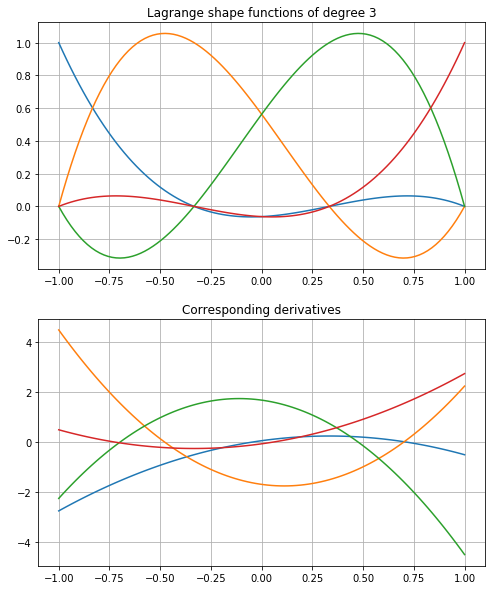

In [113]:
fig = plt.figure(figsize=(8, 10))
axes = fig.subplots(2, 1)
(ax1, ax2) = axes 

svec = np.linspace(-1,1,100)

for i in range(lag.d + 1):
    ax1.plot(svec, lag.eta[i](svec))
    ax2.plot(svec, lag.Deta[i](svec))
    
ax1.grid()
ax1.set(title='Lagrange shape functions of degree ' + str(lag.d))
ax2.grid()
ax2.set(title='Corresponding derivatives')

plt.show()

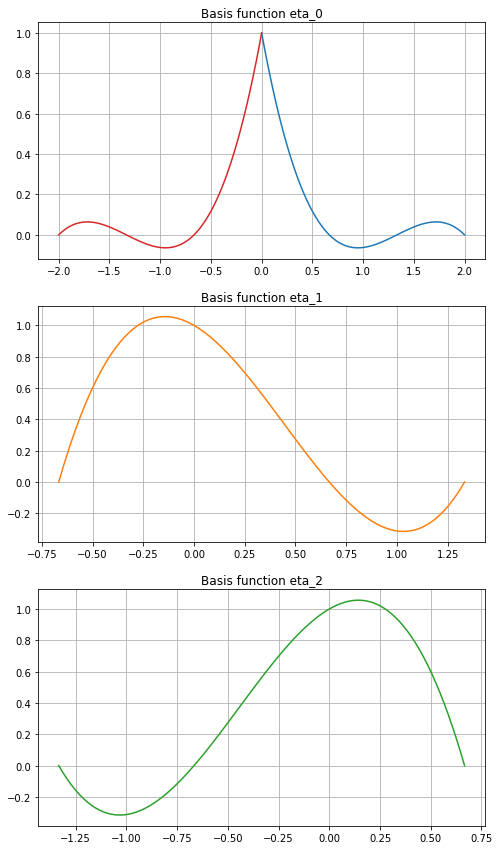

In [114]:
fig = plt.figure(figsize=(8, lag.d*6 + 2 ))
axes = fig.subplots(lag.d + 1, 1) 

for i in range(lag.d + 1):
    
    if i == lag.d:
        axes[0].plot(svec - lag.s[i], lag.eta[i](svec), color='C' + str(i))
    else:
        axes[i].plot(svec - lag.s[i], lag.eta[i](svec), color='C' + str(i))
        axes[i].grid()
        axes[i].set(title='Basis function eta_' + str(i))

fig.delaxes(axes[lag.d])
plt.show()

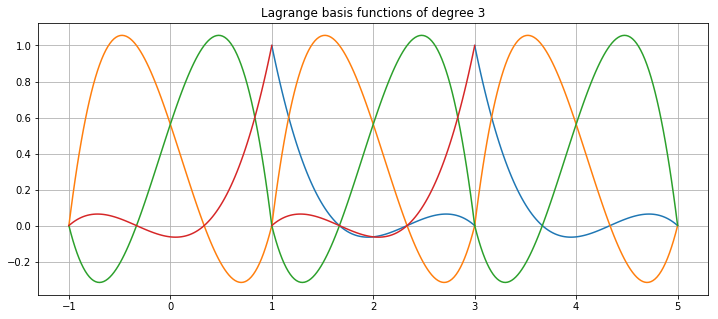

In [115]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()

for i in range(lag.d + 1):
    
    if i == 0:
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, lag.eta[i](svec), color='C' + str(i))
    elif i == lag.d:
        ax.plot(svec, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
    else:
        ax.plot(svec, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, lag.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, lag.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' + str(lag.d))

plt.show()

In [116]:
el_b = np.linspace(-np.pi, np.pi, 2**4 + 1)
# element boundaries (defining the simulation domain including the domain boundaries)
# can be any 1D array with strictly increasing entries
print('len(el_b) =', len(el_b))
print()
for i in range(len(el_b)):
    print('el_b({0}) = {1:3.2f}'.format(i, el_b[i]))

Nel = len(el_b) - 1
print('\nNel =', Nel)
# number of elements
deg = lag.d
# polynomial degree
NN = Nel*(deg + 1) - (Nel - 1)
N0 = NN - 2 
N1 = NN - 1
# number of degrees of freedom (NN including the boundary)
print('\nNN =', NN)

# mesh points

len(el_b) = 17

el_b(0) = -3.14
el_b(1) = -2.75
el_b(2) = -2.36
el_b(3) = -1.96
el_b(4) = -1.57
el_b(5) = -1.18
el_b(6) = -0.79
el_b(7) = -0.39
el_b(8) = 0.00
el_b(9) = 0.39
el_b(10) = 0.79
el_b(11) = 1.18
el_b(12) = 1.57
el_b(13) = 1.96
el_b(14) = 2.36
el_b(15) = 2.75
el_b(16) = 3.14

Nel = 16

NN = 49


In [117]:
# Mass matrix assembly:

mass0 = np.zeros((N0, N0))
print(mass0)
print()
# initiate mass matrix

# left boundary:
mass0[:lag.d, :lag.d] = (el_b[1] - el_b[0])/2*lag.mass[1:, 1:]
index = lag.d - 1
print('i =', 0)
print(mass0[:index + 1, :index + 1])
print()

# bulk:
for i in np.arange(1, Nel - 1):
    mass0[index:index + lag.d + 1, index:index + lag.d + 1] += (
        (el_b[i + 1] - el_b[i])/2*lag.mass[:, :] )
    index += lag.d
    # remark the '+=' in mass0 for the cumulative sum for overlapping degrees of freedom
    if i == 1:
        print('i =', i)
        print(mass0[:index + 1, :index + 1])
        print()
    elif i == Nel - 2:
        print('i =', i)
        print(mass0[index - lag.d:, index - lag.d:])
        print()
    
# right boundary
mass0[index:index + lag.d, index:index + lag.d] += (
        (el_b[-1] - el_b[-2])/2*lag.mass[:-1, :-1] )
print('i =', Nel - 1)
print(mass0[index - lag.d:, index - lag.d:])
print()

print(mass0)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

i = 0
[[ 0.15146965 -0.01893371 -0.00841498]
 [-0.01893371  0.15146965  0.0231412 ]
 [-0.00841498  0.0231412   0.02991993]]

i = 1
[[ 0.15146965 -0.01893371 -0.00841498  0.          0.          0.        ]
 [-0.01893371  0.15146965  0.0231412   0.          0.          0.        ]
 [-0.00841498  0.0231412   0.05983986  0.0231412  -0.00841498  0.00444124]
 [ 0.          0.          0.0231412   0.15146965 -0.01893371 -0.00841498]
 [ 0.          0.         -0.00841498 -0.01893371  0.15146965  0.0231412 ]
 [ 0.          0.          0.00444124 -0.00841498  0.0231412   0.02991993]]

i = 14
[[ 0.05983986  0.0231412  -0.00841498  0.00444124  0.          0.        ]
 [ 0.0231412   0.15146965 -0.01893371 -0.00841498  0.          0.        ]
 [-0.00841498 -0.01893371  0.15146965  0.0231412   0.          0.        ]
 [ 0.00444124 -0.00841498  0

In [118]:
# Stiffness matrix assembly:

stiff0 = np.zeros((N0, N0))
# initiate stiffness matrix

# left boundary:
stiff0[:lag.d, :lag.d] = 2/(el_b[1] - el_b[0])*lag.stiff[1:, 1:]
index = lag.d - 1

# bulk:
for i in np.arange(1, Nel - 1):
    stiff0[index:index + lag.d + 1, index:index + lag.d + 1] += (
        2/(el_b[i + 1] - el_b[i])*lag.stiff[:, :] )
    index += lag.d
    
# right boundary
stiff0[index:index + lag.d, index:index + lag.d] += (
        2/(el_b[-1] - el_b[-2])*lag.stiff[:-1, :-1] )

We want to test our implementation of the mass and stiffness matrices. In order to verify the mass matrix we test the $L^2$-projection. Let $E\in L^2((a,b))$ and denote by $\Lambda^2_0: L^2 \to V_0$ the $L^2$-projection on the finite dimensional subspace spanned by the basis functions $(\varphi_j^0)_{1 \leq j \leq N_0}$. The $L^2$-projection is defined by

$$
\be \label{L2proj}
 ( \Lambda^2_0 E - E,\, \varphi_j^0 )_{L^2} = 0 \qquad \forall\,\varphi_j^0\,.
\ee
$$

At the same time, we have

$$
\be
 (\Lambda^2_0 E)(x) = \sum_{i=1}^{N_0} e_i\,\varphi_i^0(x)\,,
\ee
$$

where $e = (e_i)_{1\leq i \leq N_0} \in \mathbb R^{N_0}$ holds the coefficients of the projected $E$ in the given basis. Moreover, we denote the mass matrix by $M^0 \in \mathbb R^{N_0 \times N_0}$ and define the vector $\overline E = (\overline E_j)_{1 \leq j \leq N_0} \in \mathbb R^{N_0}$ with $\overline E_j := (E,\,\varphi_j^0)_{L^2}$. With this, from \eqref{L2proj} we obtain

$$
\ba
 &( \Lambda^2_0 E,\, \varphi_j^0 )_{L^2} = ( E,\, \varphi_j^0 )_{L^2} \qquad \forall\,\varphi_j^0
 \\[1mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \int_a^b \varphi_i^0 \varphi_j^0\,\tn d x = \overline E_j \qquad \forall\,j   \nonumber
 \\[0mm]
 &\Leftrightarrow\quad \sum_{i=1}^{N_0} e_i \, M^0_{i,j} = \overline E_j \qquad \forall\,j  \nonumber
 \\[1mm]
 &\Leftrightarrow\quad (M^0)^\top \cdot e = \overline E   \nonumber
 \\[4mm]
 &\Leftrightarrow\quad e = (M^0)^{-1} \cdot \overline E \,.  \label{L2formula}
\ea
$$

To get to the last line we used that the mass matrix is symmetric. We shall compute the projection of a given function $E$ from formula \eqref{L2formula} and then compare $||\Lambda^2_0 E - E||_{L^2}$ for different degrees of polynomials and mesh resolution.